# Loan Defaulter Classifier

In consumer finance, lending money is a delicate balance between opportunity and risk. Loan providing companies often face challenges in lending to individuals with insufficient or non-existent credit history, thus facing the challenge of identifying potential customers who can responsibly manage their loans. This project aims to tackle that challenge by analysing historical data to identify patterns that can help predict which applicants are likely to default on their loans.

The lack of credit history information can lead to adverse outcomes, where some consumers exploit the situation and become defaulters. In this context, our project addresses two critical risks associated with loan approval decisions:
* Opportunity Loss: Failing to approve loans for applicants who are capable of repaying them results in missed business opportunities.
* Financial Loss: Approving loans for applicants likely to default can lead to significant financial losses for the company.

*PS: We would strongly recommend using the headings sections of this notebook on Jupyter Lab/Notebook for easier accessibility.*

## Team Members
* Shruti Gajipara 121233882 shruti01@umd.edu
* Aayush Verma 121331076 aver23@umd.edu
* Premal Shah 121293596 shah1305@umd.edu
* Asutosh Dalei 120997754 asutoshd@umd.edu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from collections import defaultdict

import os
import warnings
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


In [ ]:
from sklearn.preprocessing import LabelEncoder

## Datasets

In [ ]:
colDesPath = r'columns_description.csv'
appliPath = r'application_data.csv'
prevAppliPath = r'previous_application.csv'

for i in [colDesPath,appliPath,prevAppliPath]:
    print(str(i),":",os.path.getsize(i)/1e6,'mb')

columns_description.csv : 0.028348 mb
application_data.csv : 166.13337 mb
previous_application.csv : 200.278016 mb


In [ ]:
# %%time
columnDescription = pd.read_csv(colDesPath).drop(columns = ['Unnamed: 0'])
columnDescription.head()

,Table,Row,Description,Special
0,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_data,CODE_GENDER,Gender of the client,NaN
4,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [ ]:
columnDescription.Table.value_counts()

,count
Table,
application_data,122
previous_application.csv,38


In [ ]:
%%time
appData = pd.read_csv(appliPath)
print(appData.shape)
appData.head()

(307511, 122)
CPU times: user 4.76 s, sys: 709 ms, total: 5.47 s
Wall time: 5.59 s


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
defiFnx = lambda col,table='application_data': columnDescription[(columnDescription.Row == col) & (columnDescription.Table==table)]['Description'].item()

## Primary Preprocessing & Data Manipulation
**Based out on prior EDA work**

In this stage, we will perform the following preprocessing tasks:

- **Handle missing values**: Impute or remove missing data based on feature type.
- **Feature engineering**: Create new features if necessary (e.g., interaction terms or polynomial features).
- **Feature selection**: Remove highly correlated or irrelevant features to reduce dimensionality.

These steps aim to transform the data into a suitable format for modeling.


In [ ]:
# Feature Creation: missingData. To indicate the % of datapoints missing in the row.
appData = appData.assign(missingData = appData.isna().mean(axis=1)*100)

In [ ]:
# Correcting DAYS_EMPLOYED to work experience
appData['workExperience'] = (-appData['DAYS_EMPLOYED']/365).astype('float')
appData.drop(columns=['DAYS_EMPLOYED'],inplace=True)

#Number of cases where workExperience is less that 0. Since that is not possible, we will replace those rows with 0.
print("Number of cases with workEx < 0:", appData[appData['workExperience'] < 0].shape[0])

idx = appData[appData['workExperience'] < 0].index
appData.iloc[idx,appData.columns.get_loc('workExperience')] = 0

print("Number of cases with workEx < 0 after trasformation:", appData[appData['workExperience'] < 0].shape[0])

Number of cases with workEx < 0: 55374
Number of cases with workEx < 0 after trasformation: 0


In [ ]:
# Dropping rows with wrong gender
appData = appData[appData['CODE_GENDER'] != 'XNA']

In [ ]:
%%time
commCols = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
appData['mobileCommunication'] = appData[commCols].sum(axis=1)#/len(commCols)
appData.drop(columns = commCols, inplace=True)

CPU times: user 108 ms, sys: 73.4 ms, total: 181 ms
Wall time: 179 ms


In [ ]:
%%time
regCols = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
appData['region'] = appData[regCols].mean(axis=1)
appData.drop(columns = regCols, inplace=True)

CPU times: user 117 ms, sys: 49 ms, total: 166 ms
Wall time: 167 ms


In [ ]:
%%time
amtCols = [col for col in appData.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
appData['creditB'] = appData[amtCols].sum(axis=1)
appData.drop(columns = amtCols, inplace=True)

CPU times: user 135 ms, sys: 71 ms, total: 206 ms
Wall time: 203 ms


In [ ]:
docCols = [col for col in appData.columns  if 'DOCU' in col]
dropCols = []
for i in docCols:
    if i != 'FLAG_DOCUMENT_3':
        dropCols.append(i)
appData.drop(columns = dropCols, inplace=True)

In [ ]:
idx = appData[appData['OWN_CAR_AGE'].notna()].index
appData.loc[idx,'OWN_CAR_AGE'] = 1

In [ ]:
appData.isna().mean()

,0
SK_ID_CURR,0.0
TARGET,0.0
NAME_CONTRACT_TYPE,0.0
CODE_GENDER,0.0
FLAG_OWN_CAR,0.0
...,...
missingData,0.0
workExperience,0.0
mobileCommunication,0.0
region,0.0


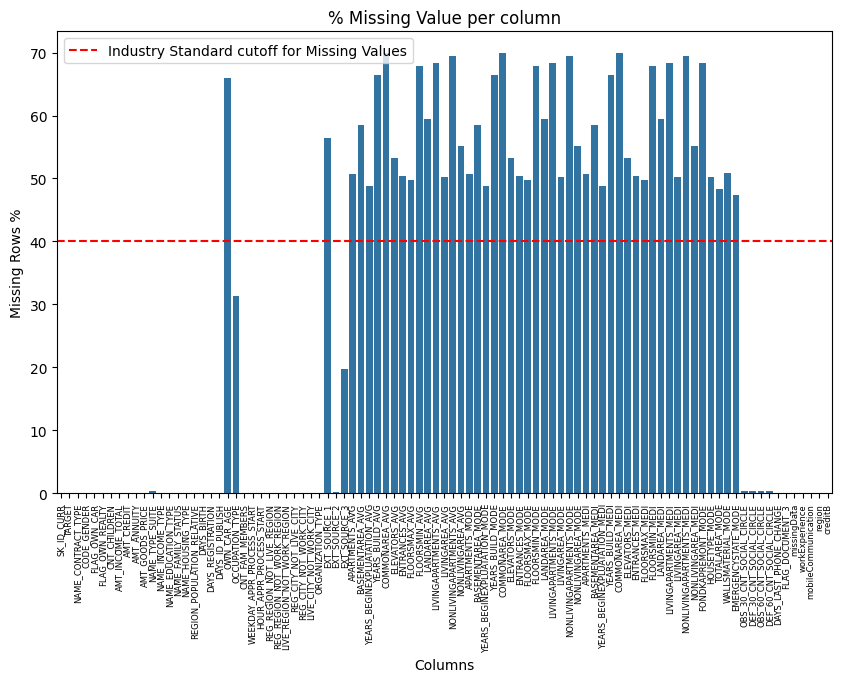

In [ ]:
plt.figure(figsize=(10,6),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
plt.axhline(y=40,color='red',linestyle = '--',label='Industry Standard cutoff for Missing Values')
plt.legend()
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

In [ ]:
missingDataCol = appData.isna().mean()
missingDataCol[missingDataCol>0.4]

,0
OWN_CAR_AGE,0.659910
EXT_SOURCE_1,0.563812
APARTMENTS_AVG,0.507501
BASEMENTAREA_AVG,0.585164
YEARS_BEGINEXPLUATATION_AVG,0.487813
YEARS_BUILD_AVG,0.664980
COMMONAREA_AVG,0.698722
ELEVATORS_AVG,0.532963
ENTRANCES_AVG,0.503491
FLOORSMAX_AVG,0.497611


In [ ]:
morethan_40percent_missing = missingDataCol[(missingDataCol>0.4)].index.tolist()
print(morethan_40percent_missing)

['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE

### Realty Columns
* These columns are linked to housing details of applicants.
* The columns have a missing data percentage of more than 40 % and have poor correlation with the TARGET variable.
* Will be dropping them.

In [ ]:
realty_ = []
for i in morethan_40percent_missing:
    if 'AVG' in i:
        realty_.append(i)
realty_

['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']

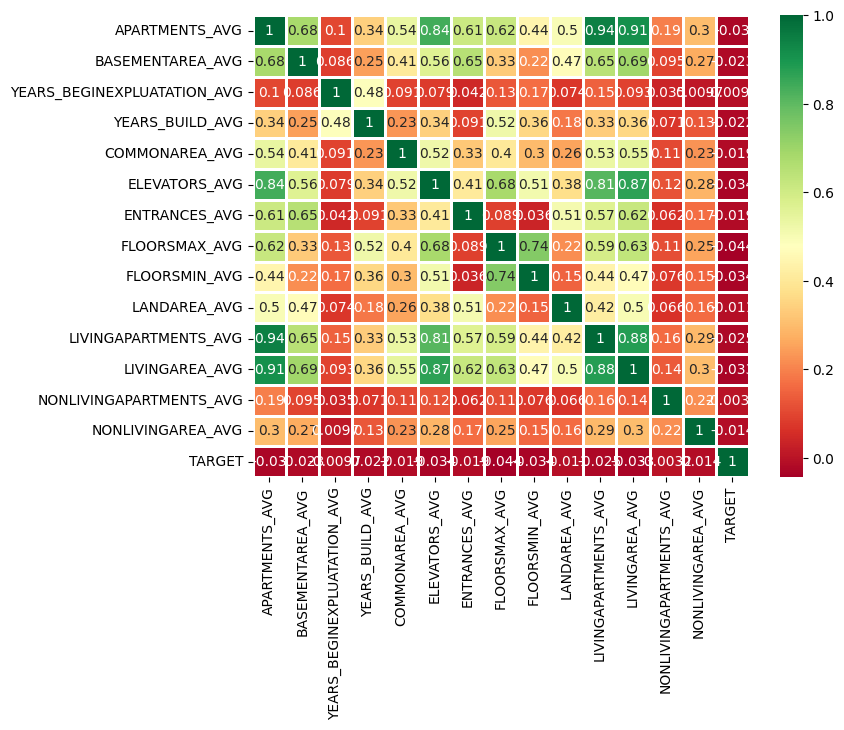

In [ ]:
suspect_col = realty_ + ['TARGET']
suspect_corr = appData[suspect_col].corr()
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)

In [ ]:
suspect_corr

,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,TARGET
APARTMENTS_AVG,1.000000,0.679390,0.100099,0.340785,0.538898,0.836957,0.611237,0.618741,0.444713,0.496849,0.943952,0.913618,0.194113,0.299716,-0.029502
BASEMENTAREA_AVG,0.679390,1.000000,0.085947,0.248602,0.405457,0.564909,0.651159,0.329841,0.220915,0.467658,0.646778,0.692893,0.095419,0.266347,-0.022747
YEARS_BEGINEXPLUATATION_AVG,0.100099,0.085947,1.000000,0.483559,0.091481,0.078922,0.042074,0.127574,0.167157,0.073915,0.146118,0.092737,0.034980,0.009665,-0.009727
YEARS_BUILD_AVG,0.340785,0.248602,0.483559,1.000000,0.232254,0.343324,0.090584,0.519204,0.359553,0.180616,0.333937,0.355669,0.070932,0.127707,-0.022150
COMMONAREA_AVG,0.538898,0.405457,0.091481,0.232254,1.000000,0.522164,0.326261,0.404011,0.295654,0.257044,0.533101,0.547029,0.105581,0.227613,-0.018551
ELEVATORS_AVG,0.836957,0.564909,0.078922,0.343324,0.522164,1.000000,0.405201,0.680076,0.511255,0.375277,0.811785,0.867775,0.121666,0.283365,-0.034202
ENTRANCES_AVG,0.611237,0.651159,0.042074,0.090584,0.326261,0.405201,1.000000,0.088696,0.035624,0.508253,0.566052,0.618878,0.061532,0.165726,-0.019175
FLOORSMAX_AVG,0.618741,0.329841,0.127574,0.519204,0.404011,0.680076,0.088696,1.000000,0.742436,0.218859,0.589757,0.630572,0.113327,0.253841,-0.044009
FLOORSMIN_AVG,0.444713,0.220915,0.167157,0.359553,0.295654,0.511255,0.035624,0.742436,1.000000,0.148220,0.438711,0.466514,0.075798,0.153109,-0.033619
LANDAREA_AVG,0.496849,0.467658,0.073915,0.180616,0.257044,0.375277,0.508253,0.218859,0.148220,1.000000,0.420081,0.501568,0.065854,0.163536,-0.010887


In [ ]:
realty_ = []
for i in morethan_40percent_missing:
    if ('AVG' in i) or ('MEDI' in i) or ('MODE' in i):
        realty_.append(i)

appData.drop(columns = realty_, inplace=True)
print(appData.shape)

(307507, 46)


### Social Circle Columns

* These columns are linked to the social circle of the applicant.
* The columns have a poor correlation with the TARGET variable.
* Will be dropping them.

In [ ]:
suspect_col = []
for i in appData.columns:
    if 'SOC' in i:
        suspect_col.append(i)
        print(f"{i}: {defiFnx(i)}")

OBS_30_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings with observable 30 DPD (days past due) default
DEF_30_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings defaulted on 30 DPD (days past due) 
OBS_60_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings with observable 60 DPD (days past due) default
DEF_60_CNT_SOCIAL_CIRCLE: How many observation of client's social surroundings defaulted on 60 (days past due) DPD


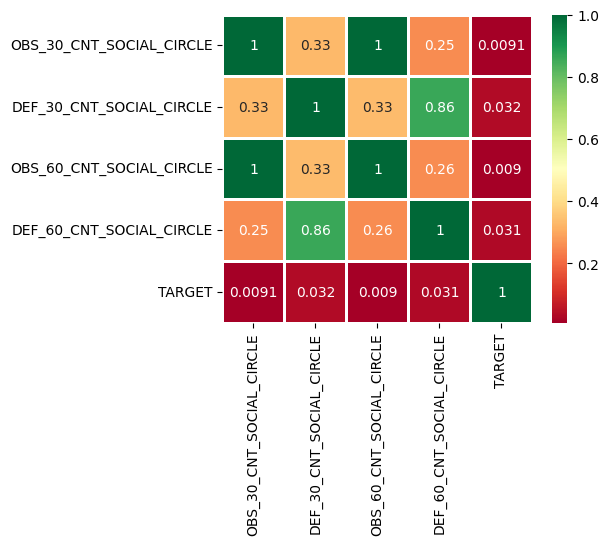

In [ ]:
suspect_corr = appData[suspect_col+['TARGET']].corr()

fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)

In [ ]:
appData.drop(columns = suspect_col, inplace=True)
print(appData.shape)

(307507, 42)


### External Datasource Columns

* These columns are linked to external data sources.
* The columns have a poor correlation with the TARGET variable.
* Will be dropping them.

In [ ]:
suspect_col = []
for i in appData.columns:
    if 'EXT' in i:
        suspect_col.append(i)
        print(f"{i}: {defiFnx(i)}")

EXT_SOURCE_1: Normalized score from external data source
EXT_SOURCE_2: Normalized score from external data source
EXT_SOURCE_3: Normalized score from external data source


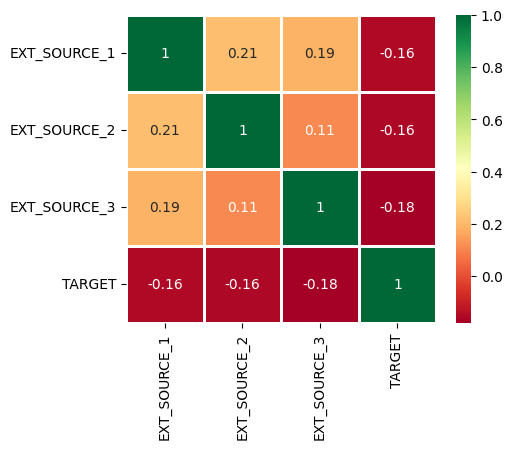

In [ ]:
suspect_corr = appData[suspect_col+['TARGET']].corr()

fig = plt.figure(figsize=(5,4))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)

In [ ]:
appData.drop(columns = suspect_col, inplace=True)
print(appData.shape)

(307507, 39)


### Fixing Day & Age Related Columns

In [ ]:
suspect_col = []
for i in appData.columns:
    if 'DAYS' in i:
        suspect_col.append(i)
        print(f"{i}: {defiFnx(i)}")

DAYS_BIRTH: Client's age in days at the time of application
DAYS_REGISTRATION: How many days before the application did client change his registration
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone


In [ ]:
appData[suspect_col]

,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,-9461,-3648.0,-2120,-1134.0
1,-16765,-1186.0,-291,-828.0
2,-19046,-4260.0,-2531,-815.0
3,-19005,-9833.0,-2437,-617.0
4,-19932,-4311.0,-3458,-1106.0
...,...,...,...,...
307506,-9327,-8456.0,-1982,-273.0
307507,-20775,-4388.0,-4090,0.0
307508,-14966,-6737.0,-5150,-1909.0
307509,-11961,-2562.0,-931,-322.0


In [ ]:
%%time
for col in suspect_col:
    appData[col] = (-appData[col]/365).astype('float')

CPU times: user 11.1 ms, sys: 28 µs, total: 11.1 ms
Wall time: 11.6 ms


In [ ]:
appData['OWN_CAR_AGE'].value_counts(dropna=False,normalize=True)

,proportion
OWN_CAR_AGE,
NaN,0.65991
1.0,0.34009


In [ ]:
appData.drop(columns = ['OWN_CAR_AGE'],inplace=True)

---
## Columns Under Consideration


In [ ]:
print('The shape of dataset after the primary preprocessing stage is as follows:')
print(f'Number of Rows: {appData.shape[0]}, Number of Columns: {appData.shape[1]}')

The shape of dataset after the primary preprocessing stage is as follows:
Number of Rows: 307507, Number of Columns: 38


In [ ]:
appData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,missingData,workExperience,mobileCommunication,region,creditB
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,Business Entity Type 3,3.106849,1,0.819672,1.745205,4,2.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,School,2.268493,1,1.639344,3.254795,4,1.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,Government,2.232877,0,39.344262,0.616438,5,2.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,Business Entity Type 3,1.690411,1,45.901639,8.326027,3,2.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1,1,Religion,3.030137,0,40.983607,8.323288,3,2.0,0.0


In [ ]:
appData.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307507 non-null  int64  
 1   TARGET                       307507 non-null  int64  
 2   NAME_CONTRACT_TYPE           307507 non-null  object 
 3   CODE_GENDER                  307507 non-null  object 
 4   FLAG_OWN_CAR                 307507 non-null  object 
 5   FLAG_OWN_REALTY              307507 non-null  object 
 6   CNT_CHILDREN                 307507 non-null  int64  
 7   AMT_INCOME_TOTAL             307507 non-null  float64
 8   AMT_CREDIT                   307507 non-null  float64
 9   AMT_ANNUITY                  307495 non-null  float64
 10  AMT_GOODS_PRICE              307229 non-null  float64
 11  NAME_TYPE_SUITE              306215 non-null  object 
 12  NAME_INCOME_TYPE             307507 non-null  object 
 13  NAME

In [ ]:
appData.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,missingData,workExperience,mobileCommunication,region,creditB
count,307507.000000,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,...,307507.000000,307507.000000,307507.000000,307506.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000
mean,278181.527256,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,43.937061,13.660634,...,0.078174,0.230457,0.179557,2.637974,0.710033,24.396051,5.355672,3.355153,2.041989,2.145655
std,102790.132982,0.27242,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,0.013831,11.956116,9.651734,...,0.268445,0.421126,0.383819,2.265237,0.453748,17.147006,6.320649,0.865273,0.499630,2.290849
min,100002.000000,0.00000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,20.517808,-0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,189146.500000,0.00000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,34.008219,5.506849,...,0.000000,0.000000,0.000000,0.750685,0.000000,4.098361,0.791781,3.000000,2.000000,0.000000
50%,278203.000000,0.00000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,43.150685,12.339726,...,0.000000,0.000000,0.000000,2.073973,1.000000,29.508197,3.323288,3.000000,2.000000,2.000000
75%,367143.500000,0.00000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,53.923288,20.491781,...,0.000000,0.000000,0.000000,4.301370,1.000000,40.163934,7.561644,4.000000,2.000000,3.000000
max,456255.000000,1.00000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,69.120548,67.594521,...,1.000000,1.000000,1.000000,11.758904,1.000000,50.000000,49.073973,6.000000,3.000000,262.000000


**Primary Preprocessing Complete**

---


## Secondary Preprocessing

In this stage, we will perform the following preprocessing tasks:

- **Handle missing values**: Impute or remove missing data based on feature type.
- **Scale/Normalize continuous variables**: Apply standardization (e.g., Z-score) or normalization (e.g., Min-Max scaling) for continuous features.
- **Encode categorical variables**: Use one-hot encoding or label encoding to convert categorical features into numerical format.
- **Outlier detection and treatment**: Identify and handle outliers using methods like Z-score or IQR.

These steps aim to transform the data into a suitable format for modeling.


In [ ]:
appData['NAME_CONTRACT_TYPE'].replace({'Cash loans':'cash','Revolving loans':'revolve'},inplace=True)

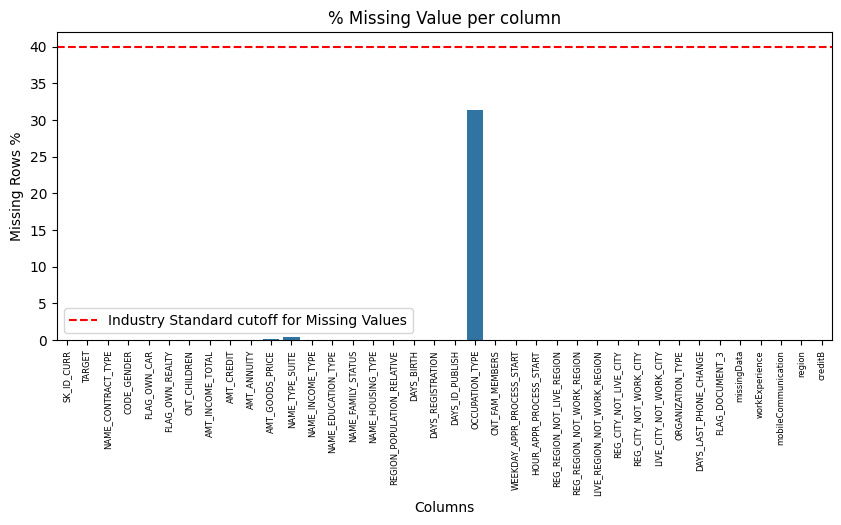

In [ ]:
plt.figure(figsize=(10,4),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
plt.axhline(y=40,color='red',linestyle = '--',label='Industry Standard cutoff for Missing Values')
plt.legend()
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

In [ ]:
appData.isna().sum()

,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,12


### Occupation Type
We can replace the NaN with 'Unknown'

In [ ]:
defiFnx('OCCUPATION_TYPE')

'What kind of occupation does the client have'

In [ ]:
appData['OCCUPATION_TYPE'].value_counts(dropna = False)

,count
OCCUPATION_TYPE,
NaN,96389
Laborers,55186
Sales staff,32102
Core staff,27569
Managers,21371
Drivers,18603
High skill tech staff,11380
Accountants,9813
Medicine staff,8537


In [ ]:
appData['OCCUPATION_TYPE'].fillna(value = 'Unkown',inplace=True)

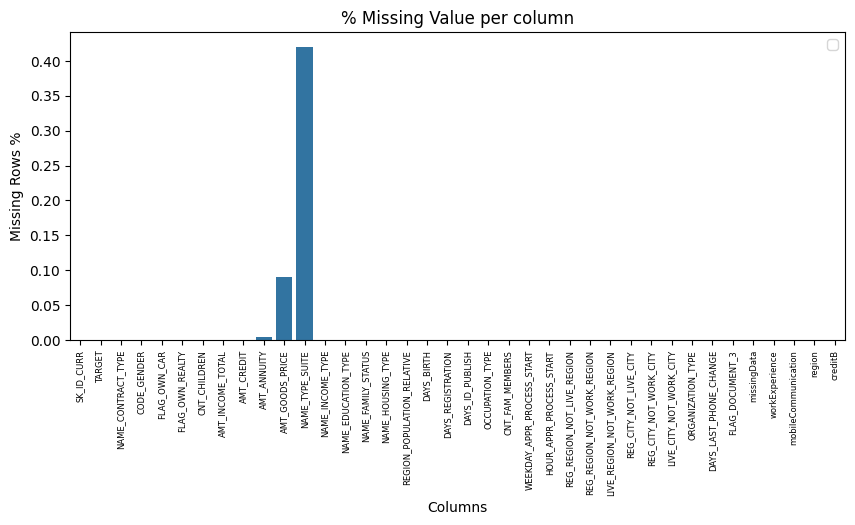

In [ ]:
plt.figure(figsize=(10,4),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
# plt.axhline(y=40,color='red',linestyle = '--',label='Industry Standard cutoff for Missing Values')
plt.legend()
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

### Application Attendance
* We will merge Family, Spouse/Partner and Children into a single category
* We will merge OtherA/B, Group and NaN into others
* The rest remains the same

In [ ]:
defiFnx('NAME_TYPE_SUITE')

'Who was accompanying client when he was applying for the loan'

In [ ]:
appData['NAME_TYPE_SUITE'].value_counts(dropna=False,normalize=True)

,proportion
NAME_TYPE_SUITE,
Unaccompanied,0.808186
Family,0.130560
"Spouse, partner",0.036975
Children,0.010624
Other_B,0.005756
NaN,0.004202
Other_A,0.002816
Group of people,0.000881


In [ ]:
appData['NAME_TYPE_SUITE'].replace(to_replace=['Spouse, partner','Children'],value='Family',inplace=True)
appData['NAME_TYPE_SUITE'].replace(to_replace=['Other_A', 'Other_B','Group of people'],value='Others',inplace=True)
appData['NAME_TYPE_SUITE'].fillna('Others',inplace=True)

appData['NAME_TYPE_SUITE'].value_counts(dropna=False,normalize=True)

,proportion
NAME_TYPE_SUITE,
Unaccompanied,0.808186
Family,0.178159
Others,0.013655


### Goods Price
* Will be replaced by the mean value of the distribution

In [ ]:
defiFnx('AMT_GOODS_PRICE')

'For consumer loans it is the price of the goods for which the loan is given'

In [ ]:
appData['AMT_GOODS_PRICE'].isna().sum()

278

In [ ]:
appData['AMT_GOODS_PRICE'].describe()

,AMT_GOODS_PRICE
count,3.072290e+05
mean,5.383977e+05
std,3.694472e+05
min,4.050000e+04
25%,2.385000e+05
50%,4.500000e+05
75%,6.795000e+05
max,4.050000e+06


In [ ]:
appData['AMT_GOODS_PRICE'].interpolate(inplace=True)
appData['AMT_GOODS_PRICE'].isna().sum()

0

In [ ]:
tt = appData.isna().sum()
tt[tt>0]

,0
AMT_ANNUITY,12
CNT_FAM_MEMBERS,2
DAYS_LAST_PHONE_CHANGE,1


### Family Member Count, Annuity & Phone Change
* We can drop the rows belonging to these columns and are NaN.
* Annunity is an important parameter in loan systems.
* The remaining columns are more or less insignificant for the target column and miniscule in number.


In [ ]:
appData.dropna(inplace=True)

In [ ]:
appData.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 307492 entries, 0 to 307510
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307492 non-null  int64  
 1   TARGET                       307492 non-null  int64  
 2   NAME_CONTRACT_TYPE           307492 non-null  object 
 3   CODE_GENDER                  307492 non-null  object 
 4   FLAG_OWN_CAR                 307492 non-null  object 
 5   FLAG_OWN_REALTY              307492 non-null  object 
 6   CNT_CHILDREN                 307492 non-null  int64  
 7   AMT_INCOME_TOTAL             307492 non-null  float64
 8   AMT_CREDIT                   307492 non-null  float64
 9   AMT_ANNUITY                  307492 non-null  float64
 10  AMT_GOODS_PRICE              307492 non-null  float64
 11  NAME_TYPE_SUITE              307492 non-null  object 
 12  NAME_INCOME_TYPE             307492 non-null  object 
 13  NAME

### Treating Categorical Variables
* Categorical variables with less than 3 unique values will be processed with OneHotEncoding
* The rest will be LabelEncoded

In [ ]:
appData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,missingData,workExperience,mobileCommunication,region,creditB
0,100002,1,cash,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,Business Entity Type 3,3.106849,1,0.819672,1.745205,4,2.0,1.0
1,100003,0,cash,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,School,2.268493,1,1.639344,3.254795,4,1.0,0.0
2,100004,0,revolve,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,Government,2.232877,0,39.344262,0.616438,5,2.0,0.0
3,100006,0,cash,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,Business Entity Type 3,1.690411,1,45.901639,8.326027,3,2.0,0.0
4,100007,0,cash,M,N,Y,0,121500.0,513000.0,21865.5,...,1,1,Religion,3.030137,0,40.983607,8.323288,3,2.0,0.0


In [ ]:
oneHotCol,labelEncCol = [],[]
for col,col_d in zip(appData.columns,appData.dtypes):
    if col_d == 'object':
        print(f"Column Name: {col}, Num Unique Values: {appData[col].nunique()}")
        if appData[col].nunique()<3:
            oneHotCol.append(col)
        else:
            labelEncCol.append(col)

Column Name: NAME_CONTRACT_TYPE, Num Unique Values: 2
Column Name: CODE_GENDER, Num Unique Values: 2
Column Name: FLAG_OWN_CAR, Num Unique Values: 2
Column Name: FLAG_OWN_REALTY, Num Unique Values: 2
Column Name: NAME_TYPE_SUITE, Num Unique Values: 3
Column Name: NAME_INCOME_TYPE, Num Unique Values: 8
Column Name: NAME_EDUCATION_TYPE, Num Unique Values: 5
Column Name: NAME_FAMILY_STATUS, Num Unique Values: 5
Column Name: NAME_HOUSING_TYPE, Num Unique Values: 6
Column Name: OCCUPATION_TYPE, Num Unique Values: 19
Column Name: WEEKDAY_APPR_PROCESS_START, Num Unique Values: 7
Column Name: ORGANIZATION_TYPE, Num Unique Values: 58


In [ ]:
print(f"Columns for Label Encoding: {labelEncCol}\n")
print(f"Columns for OneHot Encoding: {oneHotCol}")


Columns for Label Encoding: ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

Columns for OneHot Encoding: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


#### Label Encoding

In [ ]:
encoderMap = defaultdict(LabelEncoder)

In [ ]:
appData[labelEncCol] = appData[labelEncCol].apply(lambda x: encoderMap[x.name].fit_transform(x))

In [ ]:
# # To inverse transform the encoding.
# appData[labelEncCol].apply(lambda x: encoderMap[x.name].inverse_transform(x))

#### OneHot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data = pd.get_dummies(appData,columns=oneHotCol,prefix=['Contract','GENDER','CAR','REALTY'],dtype=float)
# --- Variable Reset Tag

**Secondary Preprocessing Complete**

---


## Minority Class Identification
- Asutosh Dalei

In [ ]:
print('The shape of dataset after the data preprocessing stage is as follows:')
print(f'Number of Rows: {data.shape[0]}, Number of Columns: {data.shape[1]}')

The shape of dataset after the data preprocessing stage is as follows:


NameError: name 'data' is not defined

In [ ]:
data.TARGET.value_counts(normalize=True)
plt.figure(figsize)

TARGET
0    0.919266
1    0.080734
Name: proportion, dtype: float64

In [ ]:
appData_class0=appData[appData['TARGET']==0]
x=appData.drop(columns=['TARGET','SK_ID_CURR'])
y=appData['TARGET']

In [ ]:
oneHotCol,labelEncCol = [],[]
for col,col_d in zip(appData.columns,appData.dtypes):
    if col_d == 'object':
        print(f"Column Name: {col}, Num Unique Values: {appData[col].nunique()}")
        if appData[col].nunique()<3:
            oneHotCol.append(col)
        else:
            labelEncCol.append(col)
encoderMap = defaultdict(LabelEncoder)
appData[labelEncCol] = appData[labelEncCol].apply(lambda x: encoderMap[x.name].fit_transform(x))
from sklearn.preprocessing import OneHotEncoder
data = pd.get_dummies(appData,columns=oneHotCol,prefix=['Contract','GENDER','CAR','REALTY'],dtype=float)

Column Name: NAME_CONTRACT_TYPE, Num Unique Values: 2
Column Name: CODE_GENDER, Num Unique Values: 2
Column Name: FLAG_OWN_CAR, Num Unique Values: 2
Column Name: FLAG_OWN_REALTY, Num Unique Values: 2


In [ ]:
xdata = data.iloc[:,2:]
ydata = data.iloc[:,1]

scaler = StandardScaler()
# xdata_scaled = scaler.fit_transform(xdata)

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2,random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier,CatBoostRegressor
params = {
    'depth': [4, 6,8,10],
    'learning_rate': [0.01,0.05, 0.1 ,0.2],
    'l2_leaf_reg': [1, 3, 5,9],
    'iterations': [200,400,500, 1000]
}

model_majority = CatBoostClassifier()
grid_search = GridSearchCV(model_majority, param_grid=params, cv=5, scoring='f1')
grid_search.fit(xtrain, ytrain,cat_features=categorical_columns)
best_model = grid_search.best_estimator_


KeyboardInterrupt: 

In [ ]:
catboost_model = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=100,scale_pos_weight=5)
catboost_model.fit(xtrain, ytrain, cat_features=categorical_columns, eval_set=(xtest, ytest), early_stopping_rounds=50)

0:	learn: 0.6826037	test: 0.6828094	best: 0.6828094 (0)	total: 1.91s	remaining: 9m 31s
100:	learn: 0.5660395	test: 0.5714365	best: 0.5714365 (100)	total: 1m 12s	remaining: 2m 22s
200:	learn: 0.5593055	test: 0.5676730	best: 0.5676730 (200)	total: 2m 9s	remaining: 1m 3s
299:	learn: 0.5527357	test: 0.5650873	best: 0.5650873 (299)	total: 3m 15s	remaining: 0us

bestTest = 0.5650872974
bestIteration = 299



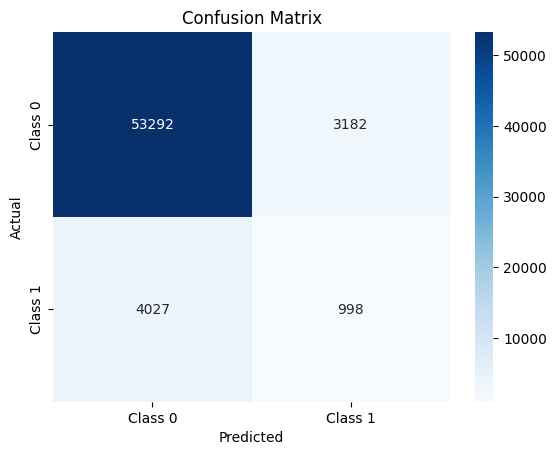

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

catboost_pred = catboost_model.predict(xtest)
catboost_probs = catboost_model.predict_proba(xtest)
cm = confusion_matrix(ytest, catboost_pred, labels=[0, 1])

# Display the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


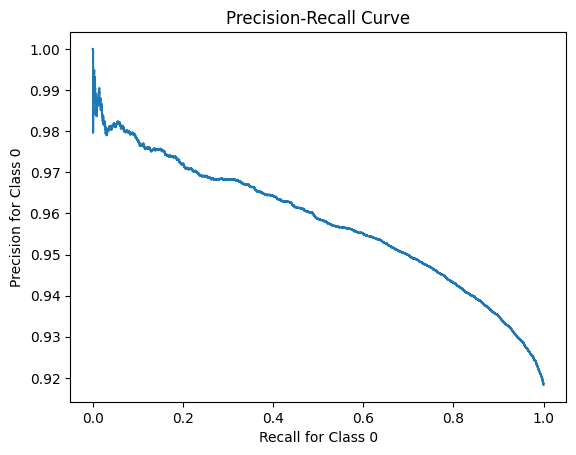

In [ ]:
from sklearn.metrics import precision_recall_curve

y_pred_prob = catboost_model.predict_proba(xtest)[:, 0]  # Probabilities for Class 0
precision, recall, thresholds = precision_recall_curve(ytest, y_pred_prob, pos_label=0)

plt.plot(recall, precision)
plt.xlabel("Recall for Class 0")
plt.ylabel("Precision for Class 0")
plt.title("Precision-Recall Curve")
plt.show()


# **CODE FOR CLASS 1 MODEL**

Column Name: NAME_CONTRACT_TYPE, Num Unique Values: 2
Column Name: CODE_GENDER, Num Unique Values: 2
Column Name: FLAG_OWN_CAR, Num Unique Values: 2
Column Name: FLAG_OWN_REALTY, Num Unique Values: 2
Column Name: NAME_TYPE_SUITE, Num Unique Values: 3
Column Name: NAME_INCOME_TYPE, Num Unique Values: 8
Column Name: NAME_EDUCATION_TYPE, Num Unique Values: 5
Column Name: NAME_FAMILY_STATUS, Num Unique Values: 5
Column Name: NAME_HOUSING_TYPE, Num Unique Values: 6
Column Name: OCCUPATION_TYPE, Num Unique Values: 19
Column Name: WEEKDAY_APPR_PROCESS_START, Num Unique Values: 7
Column Name: ORGANIZATION_TYPE, Num Unique Values: 58


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

xdata = data.iloc[:,2:]
ydata = data.iloc[:,1]

scaler = StandardScaler()
# xdata_scaled = scaler.fit_transform(xdata)

xtrain,xtest,ytrain,ytest = train_test_split(xdata,ydata,test_size=0.2,random_state=42)

idx = ytrain[ytrain == 1].index
xtrainOneClass = xdata.loc[idx]

xtrainOC_Scaled = scaler.fit_transform(xtrainOneClass)
xtest_scaled = scaler.transform(xtest)

svm_model = OneClassSVM(kernel='rbf', gamma='auto').fit(xtrainOC_Scaled)

# Predicting on test data
svm_scores = svm_model.decision_function(xtest_scaled)
svm_pred = svm_model.predict(xtest_scaled)
svm_pred[svm_pred == -1] = 0


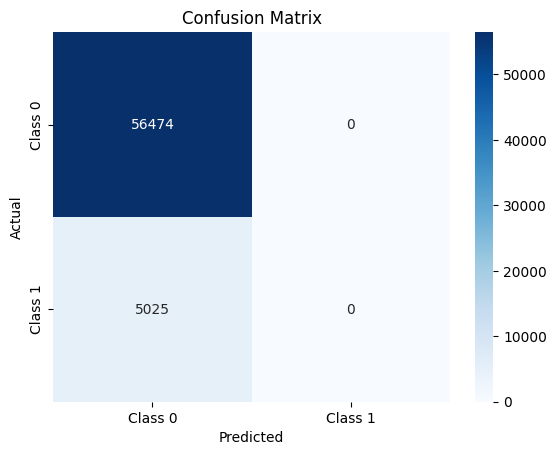

In [ ]:

cm = confusion_matrix(ytest, svm_pred, labels=[0, 1])

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# CREATING THE MODEL MODEL DECISION MAKER

In [ ]:
from sklearn.ensemble import RandomForestClassifier


meta_features = np.column_stack((
    catboost_probs[:, 1],  # Probability of Class 1 from CatBoost
    svm_scores             # Decision scores from One-Class SVM
))
meta_labels = ytest

# Train a meta-classifier
meta_model = RandomForestClassifier(random_state=42)
meta_model.fit(meta_features, meta_labels)


RandomForestClassifier(random_state=42)

# EVALUATING THE META MODEL DECISION MAKER

              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95     56474
     Class 1       0.44      0.50      0.47      5025

    accuracy                           0.91     61499
   macro avg       0.70      0.72      0.71     61499
weighted avg       0.91      0.91      0.91     61499



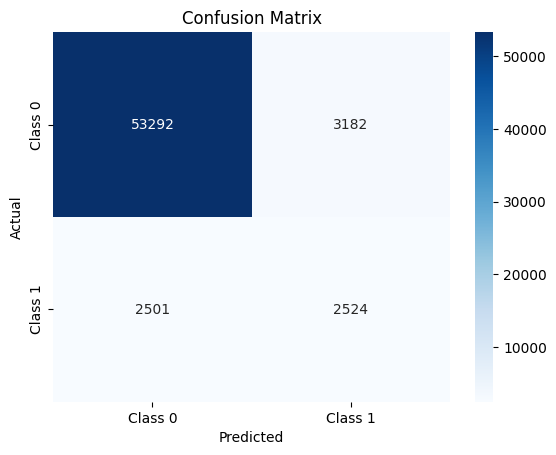

In [ ]:
# Generate meta-classifier predictions
meta_features_test = np.column_stack((
    catboost_probs[:, 1],  # Probability of Class 1 from CatBoost
    svm_scores             # Decision scores from One-Class SVM
))
meta_decisions = meta_model.predict(meta_features_test)

# Final combined predictions
final_predictions = []
for i in range(len(xtest)):
    if meta_decisions[i] == 1:  # Meta-classifier suggests using SVM for Class 1
        final_predictions.append(svm_pred[i])
    else:  # Meta-classifier suggests using CatBoost
        final_predictions.append(catboost_pred[i])

# Evaluate combined predictions
print(classification_report(ytest, final_predictions, target_names=["Class 0", "Class 1"]))

# Confusion matrix
cm = confusion_matrix(ytest, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Combined Model - Classification Report")
print(classification_report(ytest, final_predictions, target_names=["Class 0", "Class 1"]))

Combined Model - Classification Report
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95     56474
     Class 1       0.44      0.50      0.47      5025

    accuracy                           0.91     61499
   macro avg       0.70      0.72      0.71     61499
weighted avg       0.91      0.91      0.91     61499



Combined Model AUC-ROC: 1.0000


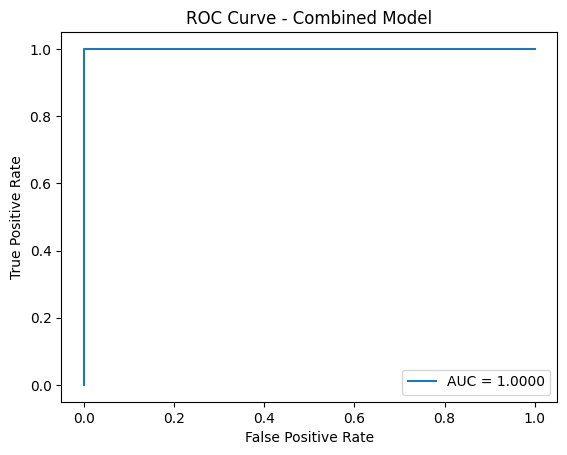

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Probability for Class 1 (from the combined decision)
meta_features_test = np.column_stack((catboost_probs[:, 1], svm_scores))
meta_decisions = meta_model.predict_proba(meta_features_test)[:, 1]

# Compute AUC-ROC
auc = roc_auc_score(ytest, meta_decisions)
print(f"Combined Model AUC-ROC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(ytest, meta_decisions)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined Model")
plt.legend(loc="lower right")
plt.show()


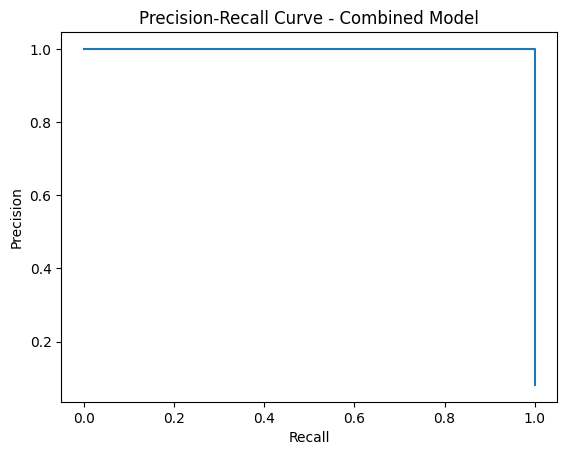

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(ytest, meta_decisions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Combined Model")
plt.show()
